In [97]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
import os,time,datetime,sys

### 1D Inverse Problem

$$

\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& U = \begin{bmatrix}
\rho \\
\rho u \\
\rho E
\end{bmatrix}
\quad
f(U) = \begin{bmatrix}
\rho u\\
\rho u^2 +p \\
u(\rho E+p)
\end{bmatrix}, \quad p=(\gamma-1)(\rho E-\frac{1}{2}\rho||u||^2), \quad \gamma=1.4  \\
\\
&\text{IC}\\
& \qquad \text{initial shock is given at } x=0.0\\
& \qquad (\rho_L,u_L,p_L)=(1,0,1) \qquad (\rho_R,u_R,p_R)=(0.125,0,0.1) \\

\end{aligned}

$$


### PINNs Model

In [98]:
class PINN(tf.keras.Model):
    def __init__(
            self,
            t,x,u,t_r,x_r,lb,ub,
            in_dim,out_dim,width,depth,
            activ="tanh",w_init="glorot_normal",b_init="zeros",
            lr=1e-3,opt="Adam",
            info_seed=1234):
        super().__init__()
        # information
        self.info_seed = info_seed
        # initial the data
        self.data_type = tf.float32
        self.x = tf.convert_to_tensor(x,dtype=self.data_type)
        self.t = tf.convert_to_tensor(t,dtype=self.data_type)
        self.u = tf.convert_to_tensor(u,dtype=self.data_type)
        # pde loss train point = inner + outer(initial+boundary)
        t_r = tf.concat([t,t_r],axis=0)
        x_r = tf.concat([x,x_r],axis=0)
        self.x_r = tf.convert_to_tensor(x_r,dtype=self.data_type)
        self.t_r = tf.convert_to_tensor(t_r,dtype=self.data_type)
        self.lb = tf.convert_to_tensor(lb,dtype=self.data_type)
        self.ub = tf.convert_to_tensor(ub,dtype=self.data_type)
        # neuron network configuration
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.width = width
        self.depth = depth
        self.activ = activ
        self.w_init = w_init
        self.b_init = b_init
        self.lr = lr
        self.opt = opt
        
        # call
        self.dnn = self.dnn_init()
        self.params = self.dnn.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

        # track loss
        self.ep_log = []
        self.loss_log = []

        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
    
    def dnn_init(self):
        net = tf.keras.Sequential()
        net.add(tf.keras.layers.InputLayer(self.in_dim))
        # net.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        for l in range(self.depth - 1):
            net.add(tf.keras.layers.Dense(units=self.width, activation = self.activ,kernel_initializer = self.w_init, bias_initializer = self.b_init))
        net.add(tf.keras.layers.Dense(self.out_dim))
        return net

    
    def loss_pde(self):
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(self.t_r)
            tp.watch(self.x_r)
            u = self.dnn(tf.concat([self.t_r,self.x_r],1))
            rho = u[:,0][:,None]
            v = u[:,1][:,None]
            p = u[:,2][:,None]
        rho_t = tp.gradient(rho,self.t_r)
        v_t = tp.gradient(v,self.t_r)
        p_t = tp.gradient(p,self.t_r)
        rho_x = tp.gradient(rho,self.x_r)
        v_x = tp.gradient(v,self.x_r)
        p_x = tp.gradient(p,self.x_r)
        del tp
        equ_1 = rho_t + rho_x*v + rho*v_x
        equ_2 = (rho_t*v + rho*v_t) + (rho*(2*v*v_x) +(v**2)*rho_x + p_x)
        equ_3 = (5/2*p_t+1/2*rho_t*v*v+rho*v*v_t)+(v_x*(7/2*p+1/2*rho*v*v)+v*(7/2*p_x+1/2*rho_x*v*v+rho*v*v_x))
        loss = tf.reduce_mean(tf.square(equ_1)+tf.square(equ_2)+tf.square(equ_3))
        return loss

    def loss_icbc(self):
        u_nn = self.dnn(tf.concat([self.t,self.x],1))
        return tf.reduce_mean(tf.square(self.u-u_nn))*self.out_dim

    @tf.function
    def grad_desc(self):
        with tf.GradientTape() as tp:
            loss = self.loss_pde() + self.loss_icbc()
        grad = tp.gradient(loss,self.params)
        del tp
        self.optimizer.apply_gradients(zip(grad,self.params))
        return loss
    
    def train(self,epoch,tol,info_freq):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         convergence tol:", tol)
        t0 = time.time()
        for ep in range(epoch+1):
            ep_loss = self.grad_desc()
            if ep % info_freq ==0:
                elps = time.time() -t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            if ep_loss < tol:
                print(">>>>> end time:", datetime.datetime.now())
                break
        print(">>>>> end time:", datetime.datetime.now())

    def predict(self,t,x):
        return self.dnn(tf.concat([t,x],1))

### Structure of the Costum PINNs

In [99]:
in_dim = 2
out_dim = 3
width = 20
depth = 7

epoch = 120000
tol = 1e-9

w_init = "glorot_normal"
b_init = "zeros"
act = "tanh"

lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 1e-2,
    decay_steps = epoch,
    alpha = 1e-2
)


opt = "Adam"
info_freq = 500
info_seed = 1234


print("python    :", sys.version)
print("tensorflow:", tf.__version__)
print("rand seed :", info_seed)
os.environ["PYTHONHASHSEED"] = str(info_seed)

python    : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
tensorflow: 2.8.2
rand seed : 1234


### 1D Inverse Problem

$$

\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& U = \begin{bmatrix}
\rho \\
\rho u \\
\rho E
\end{bmatrix}
\quad
f(U) = \begin{bmatrix}
\rho u\\
\rho u^2 +p \\
u(\rho E+p)
\end{bmatrix}, \quad p=(\gamma-1)(\rho E-\frac{1}{2}\rho||u||^2), \quad \gamma=1.4  \\
\\
&\text{IC}\\
& \qquad \text{initial shock is given at } x=0.0\\
& \qquad (\rho_L,u_L,p_L)=(1,0,1) \qquad (\rho_R,u_R,p_R)=(0.125,0,0.1) \\

\end{aligned}

$$


In [100]:
tmin, tmax = 0., 1.
xmin, xmax = -2.5, 2.5
xshock = 0.0
N_0 = 60
N_r = 1480
lb = tf.constant([tmin, xmin], dtype = tf.float32)
ub = tf.constant([tmax, xmax], dtype = tf.float32)

t_0 = tf.ones((N_0, 1), dtype = tf.float32) * lb[0]
x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype = tf.float32)
u_0 = tf.convert_to_tensor([[1.0 if x<xshock else 0.125 ,0.,1.0 if x<xshock else 0.1] for x in x_0.numpy()],dtype=tf.float32)

t_r_rand = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
x_r_rand = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = tf.float32)


In [101]:
t_r = np.linspace(tmin,tmax,20)
x_r = np.linspace(xmin,xmax,50)
x_r,t_r = np.meshgrid(x_r,t_r)
t_r = tf.convert_to_tensor(t_r.flatten(),dtype=tf.float32)[:,None]
x_r = tf.convert_to_tensor(x_r.flatten(),dtype=tf.float32)[:,None]

tmp_t = np.linspace(0,1,40)
noise = 0.1
tmp_x_1 = tf.concat([tmp_t*(1+np.random.randn()*noise),tmp_t*(1+np.random.randn()*noise),tmp_t*(1+np.random.randn()*noise)],0)
tmp_x_2 = tf.concat([tmp_t*(np.random.randn()*noise),tmp_t*(np.random.randn()*noise),tmp_t*(np.random.randn()*noise)],0)
tmp_x_3 = tf.concat([tmp_t*(-1+np.random.randn()*noise),tmp_t*(-1+np.random.randn()*noise),tmp_t*(-1+np.random.randn()*noise)],0)
tmp_x_4 = tf.concat([tmp_t*(2+np.random.randn()*noise),tmp_t*(2+np.random.randn()*noise),tmp_t*(2+np.random.randn()*noise)],0)

tmp_x = tf.cast(tf.concat([tmp_x_1,tmp_x_2,tmp_x_3,tmp_x_4],0),dtype=tf.float32)[:,None]
tmp_t = tf.convert_to_tensor(np.array([tmp_t for i in range(12)]).flatten(),dtype=tf.float32)[:,None]

t_r_clus = tf.concat([t_r,tmp_t],0)
x_r_clus = tf.concat([x_r,tmp_x],0)


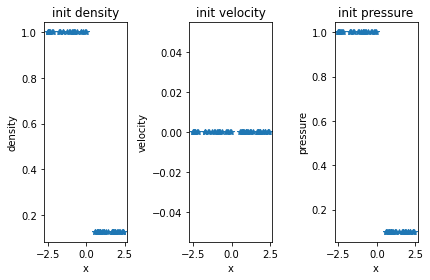

In [102]:
fig,ax = plt.subplots(1,3)
ax[0].plot(x_0,u_0[:,0],"*")
ax[0].set_title("init density")
ax[0].set_xlabel("x")
ax[0].set_ylabel("density")

ax[1].plot(x_0,u_0[:,1],"*")
ax[1].set_title("init velocity")
ax[1].set_xlabel("x")
ax[1].set_ylabel("velocity")

ax[2].plot(x_0,u_0[:,2],"*")
ax[2].set_title("init pressure")
ax[2].set_xlabel("x")
ax[2].set_ylabel("pressure")

fig.tight_layout()

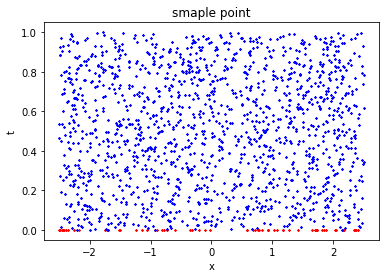

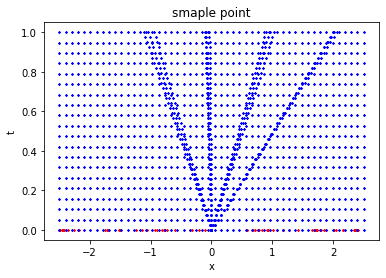

In [103]:
fig1,ax1 = plt.subplots(1)
ax1.set_ylabel("t")
ax1.set_xlabel("x")
ax1.set_title("smaple point")
ax1.plot(x_0,t_0,"*",color="r",markersize=2)
ax1.plot(x_r_rand,t_r_rand,"*",color="b",markersize=2)

fig1,ax1 = plt.subplots(1)
ax1.set_ylabel("t")
ax1.set_xlabel("x")
ax1.set_title("smaple point")
ax1.plot(x_0,t_0,"*",color="r",markersize=2)
ax1.plot(x_r_clus,t_r_clus,"*",color="b",markersize=2)


In [104]:
pinn_clus = PINN(
            t_0,x_0,u_0,
            t_r_clus,x_r_clus,
            lb,ub,
            in_dim,out_dim,width,depth,
            act,w_init,b_init,
            lr,opt,info_seed)

>>>>> start time: 2022-07-24 07:29:45.351123
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizer_v2.learning_rate_schedule.CosineDecay object at 0x7f40851e2450>
         optimizer    : Adam
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 20)                60        
                                                                 
 dense_85 (Dense)            (None, 20)                420       
                                                                 
 dense_86 (Dense)            (None, 20)                420       
                                                                 
 dense_87 (Dense)            (None, 20)                420       
                                                                 
 dense_

In [105]:
pinn_clus.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 120000
         convergence tol: 1e-09
ep: 0, loss: 1.620e+00, elps: 2.128
ep: 500, loss: 3.655e-03, elps: 2.424
ep: 1000, loss: 2.001e-03, elps: 2.426
ep: 1500, loss: 3.548e-03, elps: 2.423
ep: 2000, loss: 1.098e-03, elps: 2.412
ep: 2500, loss: 1.315e-03, elps: 2.414
ep: 3000, loss: 7.392e-04, elps: 2.390
ep: 3500, loss: 1.731e-03, elps: 2.341
ep: 4000, loss: 9.371e-04, elps: 2.379
ep: 4500, loss: 6.469e-04, elps: 2.397
ep: 5000, loss: 9.139e-04, elps: 2.369
ep: 5500, loss: 4.301e-04, elps: 2.352
ep: 6000, loss: 1.237e-03, elps: 2.381
ep: 6500, loss: 9.004e-04, elps: 2.394
ep: 7000, loss: 7.624e-04, elps: 2.412
ep: 7500, loss: 6.811e-04, elps: 2.369
ep: 8000, loss: 1.241e-03, elps: 2.389
ep: 8500, loss: 8.094e-04, elps: 2.376
ep: 9000, loss: 3.933e-04, elps: 2.369
ep: 9500, loss: 7.217e-04, elps: 2.369
ep: 10000, loss: 6.139e-04, elps: 2.377
ep: 10500, loss: 3.435e-04, elps: 2.408
ep: 11000, loss: 5.197e-04, elps: 2.369
ep: 11500, loss

In [106]:
pinn_rand = PINN(
          t_0,x_0,u_0,
          t_r_rand,x_r_rand,
          lb,ub,
          in_dim,out_dim,width,depth,
          act,w_init,b_init,
          lr,opt,info_seed)

>>>>> start time: 2022-07-24 07:38:53.752933
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizer_v2.learning_rate_schedule.CosineDecay object at 0x7f40851e2450>
         optimizer    : Adam
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 20)                60        
                                                                 
 dense_92 (Dense)            (None, 20)                420       
                                                                 
 dense_93 (Dense)            (None, 20)                420       
                                                                 
 dense_94 (Dense)            (None, 20)                420       
                                                                 
 dense_

In [107]:
pinn_rand.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 120000
         convergence tol: 1e-09
ep: 0, loss: 1.714e+00, elps: 1.618
ep: 500, loss: 2.098e-03, elps: 2.170
ep: 1000, loss: 1.360e-03, elps: 2.142
ep: 1500, loss: 1.136e-03, elps: 2.125
ep: 2000, loss: 2.273e-03, elps: 2.123
ep: 2500, loss: 6.872e-04, elps: 2.153
ep: 3000, loss: 7.275e-04, elps: 2.138
ep: 3500, loss: 3.926e-04, elps: 2.141
ep: 4000, loss: 4.496e-04, elps: 2.134
ep: 4500, loss: 4.013e-04, elps: 2.139
ep: 5000, loss: 7.320e-04, elps: 2.207
ep: 5500, loss: 3.535e-04, elps: 2.168
ep: 6000, loss: 2.748e-04, elps: 2.179
ep: 6500, loss: 1.436e-03, elps: 2.213
ep: 7000, loss: 1.744e-04, elps: 2.255
ep: 7500, loss: 2.295e-04, elps: 2.240
ep: 8000, loss: 1.233e-04, elps: 2.204
ep: 8500, loss: 2.384e-04, elps: 2.232
ep: 9000, loss: 1.914e-04, elps: 2.222
ep: 9500, loss: 1.158e-04, elps: 2.286
ep: 10000, loss: 1.813e-04, elps: 2.412
ep: 10500, loss: 3.569e-04, elps: 2.338
ep: 11000, loss: 3.250e-04, elps: 2.215
ep: 11500, loss

### Visualization

> LOSS

Text(0.5, 1.0, 'train loss(part)')

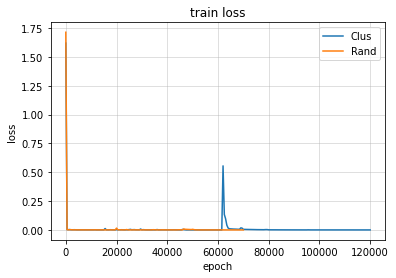

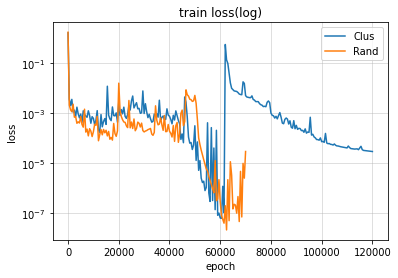

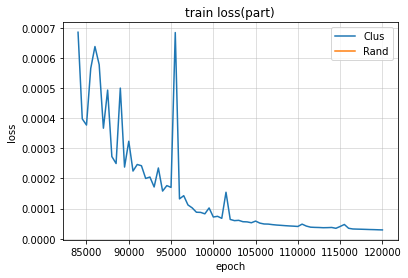

In [108]:
fig1,ax1 = plt.subplots(1)
ax1.plot(pinn_clus.ep_log,pinn_clus.loss_log,label="Clus")
ax1.plot(pinn_rand.ep_log,pinn_rand.loss_log,label="Rand")
ax1.grid(alpha=0.5)
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.set_title("train loss")
ax1.legend(loc='upper right')

fig2,ax2 = plt.subplots(1)
ax2.plot(pinn_clus.ep_log,pinn_clus.loss_log,label="Clus")
ax2.plot(pinn_rand.ep_log,pinn_rand.loss_log,label="Rand")
ax2.grid(alpha=0.5)
ax2.set_ylabel("loss")
ax2.set_xlabel("epoch")
ax2.set_yscale("log")
ax2.set_title("train loss(log)")
ax2.legend(loc='upper right')

fig3,ax3 = plt.subplots(1)
strt = int(len(pinn_clus.ep_log)*0.7)
ax3.plot(pinn_clus.ep_log[strt:],pinn_clus.loss_log[strt:],label="Clus")
ax3.plot(pinn_rand.ep_log[strt:],pinn_rand.loss_log[strt:],label="Rand")
ax3.grid(alpha=0.5)
ax3.set_xlabel("epoch")
ax3.set_ylabel("loss")
ax3.legend(loc='upper right')
ax3.set_title("train loss(part)")



### Solution in domain

In [109]:
t = np.linspace(tmin,tmax,1001)
x = np.linspace(xmin,xmax,1001)
t,x = np.meshgrid(t,x)
u_clus = pinn_clus.predict(t.flatten()[:,None],x.flatten()[:,None])
u_rand = pinn_rand.predict(t.flatten()[:,None],x.flatten()[:,None])
density_clus = u_clus[:,0].numpy().reshape(-1,len(t[0])).T
velocity_clus = u_clus[:,1].numpy().reshape(-1,len(t[0])).T
pressure_clus = u_clus[:,2].numpy().reshape(-1,len(t[0])).T

density_rand = u_rand[:,0].numpy().reshape(-1,len(t[0])).T
velocity_rand = u_rand[:,1].numpy().reshape(-1,len(t[0])).T
pressure_rand = u_rand[:,2].numpy().reshape(-1,len(t[0])).T


> Plot

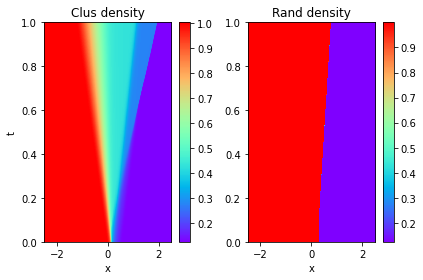

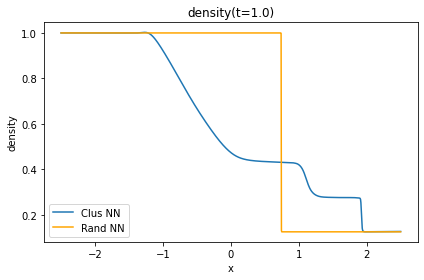

In [110]:
fig1,ax1 =plt.subplots(1,2)
img1 = ax1[0].imshow(density_clus,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
img2 = ax1[1].imshow(density_rand,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
plt.colorbar(img1,ax=ax1[0])
plt.colorbar(img2,ax=ax1[1])
ax1[0].set_title("Clus density")
ax1[0].set_xlabel('x') 
ax1[0].set_ylabel('t')
ax1[1].set_title("Rand density")
ax1[1].set_xlabel('x')
fig1.tight_layout()

fig1,ax1 = plt.subplots(1)
ax1.set_title(f"density(t={tmax})")
ax1.set_xlabel('x')
ax1.set_ylabel('density')
ax1.plot(x[:,0],density_clus[-1],label="Clus NN")
ax1.plot(x[:,0],density_rand[-1],color="orange",label="Rand NN",markersize=3)
ax1.legend(loc="lower left")

fig1.tight_layout()

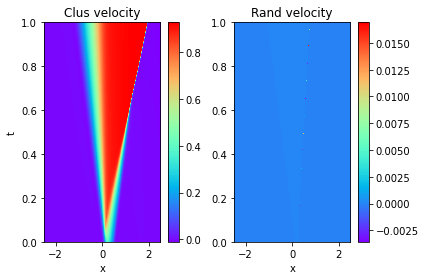

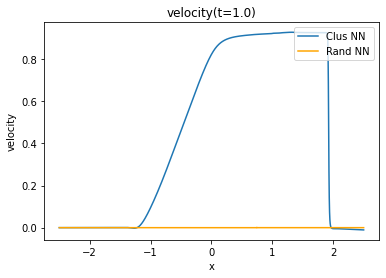

In [111]:

fig2,ax2 =plt.subplots(1,2)
img1 = ax2[0].imshow(velocity_clus,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
img2 = ax2[1].imshow(velocity_rand,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
plt.colorbar(img1,ax=ax2[0])
plt.colorbar(img2,ax=ax2[1])
ax2[0].set_title("Clus velocity")
ax2[0].set_xlabel('x')
ax2[0].set_ylabel('t')
ax2[1].set_title("Rand velocity")
ax2[1].set_xlabel('x')
fig2.tight_layout()

fig2,ax2 = plt.subplots(1)
ax2.set_title(f"velocity(t={tmax})")
ax2.set_xlabel('x')
ax2.set_ylabel('velocity')
ax2.plot(x[:,0],velocity_clus[-1],label="Clus NN")
ax2.plot(x[:,0],velocity_rand[-1],color="orange",label="Rand NN",markersize=3)
ax2.legend(loc="upper right")



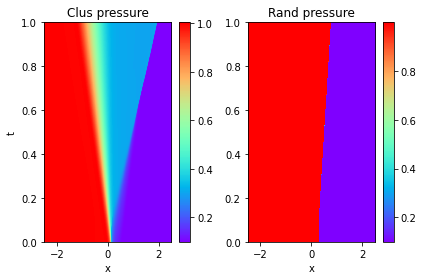

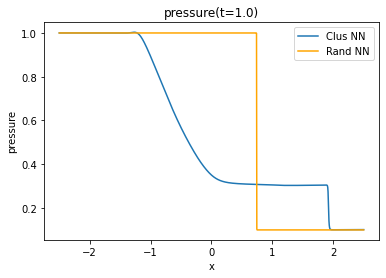

In [112]:

fig3,ax3 =plt.subplots(1,2)
img1 = ax3[0].imshow(pressure_clus,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
img2 = ax3[1].imshow(pressure_rand,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
plt.colorbar(img1,ax=ax3[0])
plt.colorbar(img2,ax=ax3[1])
ax3[0].set_title("Clus pressure")
ax3[0].set_xlabel('x') 
ax3[0].set_ylabel('t')
ax3[1].set_title("Rand pressure")
ax3[1].set_xlabel('x')
fig3.tight_layout()

fig3,ax3 = plt.subplots(1)
ax3.set_title(f"pressure(t={tmax})")
ax3.set_xlabel('x')
ax3.set_ylabel('pressure')
ax3.plot(x[:,0],pressure_clus[-1],label="Clus NN")
ax3.plot(x[:,0],pressure_rand[-1],color="orange",label="Rand NN",markersize=3)
ax3.legend(loc="upper right")
